In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from apps import cex_analyse, cex_toy_generator, cex_toy_parameters, cex_fit_studies, cex_systematics
from python.analysis import cross_section, Plots, Fitting

from IPython.display import clear_output

from rich import print

cross_section.SetPlotStyle(True, dpi = 100)

def Analyse(analysis_input : cross_section.AnalysisInput, model : cross_section.pyhf.Model, args : cross_section.argparse.Namespace, energy_slices : cross_section.Slices, mean_track_score_bins : np.array, book : Plots.PlotBook = Plots.PlotBook.null):

    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, model, mc_stat_unc = args.fit["mc_stat_unc"], single_bin = args.fit["single_bin"])

    _, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(analysis_input, args.signal_process, energy_slices, region_fit_result, args.fit["single_bin"], args.fit["regions"], args.toy_template, book) #? make separate background subtraction function?


    if args.fit["regions"]:
        histograms_reco_obs = {**histograms_reco_obs, **histograms_reco_obs["int_ex"]}
        histograms_reco_obs.pop("int_ex")
        histograms_reco_obs_err = {**histograms_reco_obs_err, **histograms_reco_obs_err["int_ex"]}
        histograms_reco_obs_err.pop("int_ex")
        # histogram_true_obs = {**histogram_true_obs, **histogram_true_obs["int_ex"]}
        # histogram_true_obs.pop("int_ex")

    unfolding_result = cex_analyse.Unfolding(histograms_reco_obs, histograms_reco_obs_err, args.toy_template, args.unfolding, args.signal_process, len(analysis_input.KE_init_reco)/len(args.toy_template.KE_init_reco), energy_slices, args.fit["regions"], None, book)

    if book is not None:
        for p in cex_analyse.process_labels:
            hist_true = analysis_input.CreateHistograms(args.energy_slices, p, False, None)["int_ex"]
            Plots.Plot(args.energy_slices.pos_overflow, unfolding_result[p]["unfolded"], yerr = cross_section.quadsum([unfolding_result[p]["stat_err"], unfolding_result[p]["sys_err"]], 0), xlabel = f"$N_{{int, {cex_analyse.process_labels[p]}}}$ (MeV)", ylabel = "Counts", label = "unfolded", style = "step", color = "C6")
            Plots.Plot(args.energy_slices.pos_overflow, hist_true, label = "true", style = "step", color = "C0", newFigure = False)
            book.Save()

    xs = cex_analyse.XSUnfold(unfolding_result, args.energy_slices, True, True, args.fit["regions"])
    return xs 


def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2, beam_profile : str = "gaussian", max_cpus : int = 11):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs,
    "max_cpus" : max_cpus
    }


def SysErr(nominal, modified):
    res = np.nan_to_num(nominal - modified)

    low = res > 0 # the nominal value is higher than the modified, so the change is small
    high = ~low
    
    err_low = abs(np.where(low, res, 0))
    err_high = abs(np.where(high, res, 0))

    return err_low, err_high


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


# Load data

In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/analysis_config.json"))
args.toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/analysis_2GeV_new_pfo_selection/toy_template_2cm.hdf5"))
energy_overflow = args.energy_slices.pos_overflow

In [3]:
model = cross_section.RegionFit.CreateModel(args.toy_template, args.energy_slices, args.fit["mean_track_score"], False, None, args.fit["mc_stat_unc"], True, args.fit["single_bin"])

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]


In [4]:
toy_config_nominal = cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/toy_data_config.json")
toy_config_nominal["seed"] = 1
toy_config_nominal["max_cpus"] = 10
toy_config_nominal["events"] = int(5E4)
toy_config_nominal["verbose"] = False

In [5]:
toy_nominal = cross_section.Toy(df = cex_toy_generator.run(toy_config_nominal))

Simulating |████████████████████████████████████████| 1/1 [100%] in 2.5s (0.40/s) 


'BeamSelectionEfficiency' executed in 0.0044s

'GenerateRecoRegions' executed in 0.0502s

'MeanTrackScore' executed in 0.1938s

'main' executed in 2.9315s

In [6]:
analysis_input_nominal = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_nominal)
with Plots.PlotBook("xs_nominal", False) as book:
    xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None, None)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-9684709.46126256])
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 3.90822e+07 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -1.47818e-07
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -1.99764e-07
W MnPosDef Added to diagonal of Error matrix a value 0.500001
W VariableMetricBuilder gdel = -1.93212e+13
init
Iteration 1: ts = 0.0027, ts_stopping = 0.01
int
Iteration 1: ts = 0.0030, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.0131, ts_stopping = 0.01
Iteration 2: ts = 0.0073, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0200, ts_stopping = 0.01
Iteration 2: ts = 0.0060, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.0040, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0074,

# MC Stat uncertainty

In [16]:
def PseudoExperiment(n_experiments, n_data, n_template):
    data_config = {k : v for k, v in toy_config_nominal.items()}
    data_config["seed"] = None
    data_config["events"] = n_data

    template_config = {k : v for k, v in toy_config_nominal.items()}
    template_config["seed"] = None
    template_config["events"] = n_template

    xs = []
    for i in range(n_experiments):
        print(f"{i=}")
        ai_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(template_config)))
        ai_data = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(data_config)))
        xs.append(Analyse(ai_data, ai_template, args, args.energy_slices, None, None))
        clear_output()        

    return np.array(xs)

n_experiments = 101
n_data = 72780
n_template = 29452

xs = PseudoExperiment(n_experiments, n_data, n_template)

In [33]:
cross_section.SaveObject("test/mc_stat_results.dill", xs)

[ 197.55162786   44.48241306   23.86933826   13.75573954   11.01124382
   11.0247282    11.37993186   15.63823666   18.54181752   23.8417464
   31.20114062   41.7196889    44.78570444 2252.82976052]

[ 165.31481988   49.5700049    41.69310365   45.94448584   50.52706997
   54.3725391    59.37011065   63.19353946   70.26495323   74.90966112
   86.46898951   90.01963669   87.43404877 4735.94521514]

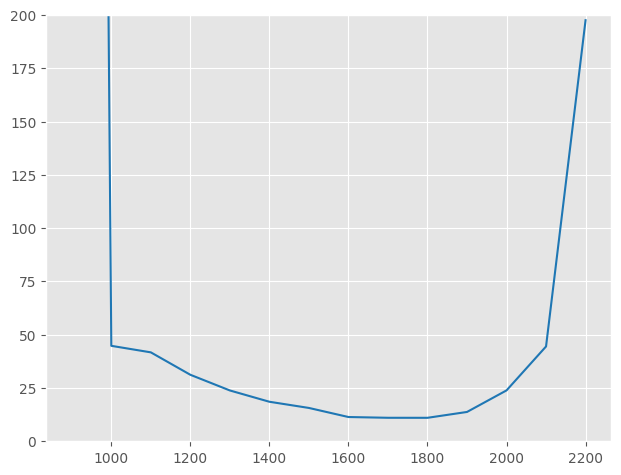

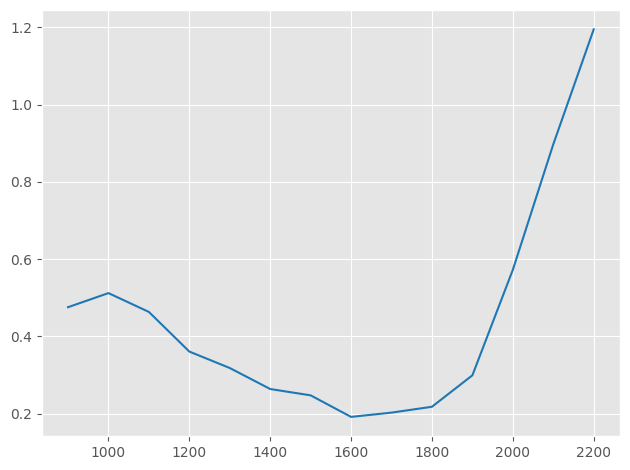

In [27]:
# cv = xs[0][0]
cv = np.nanmean(xs[:, 0], 0)
res = xs[:, 0] - cv

mean = np.nanmean(abs(res), 0)
print(mean)
print(cv)
Plots.Plot(args.energy_slices.pos, mean)
Plots.plt.ylim(0, 200)

Plots.Plot(args.energy_slices.pos, mean/cv)

# Region fit normalisation systematic

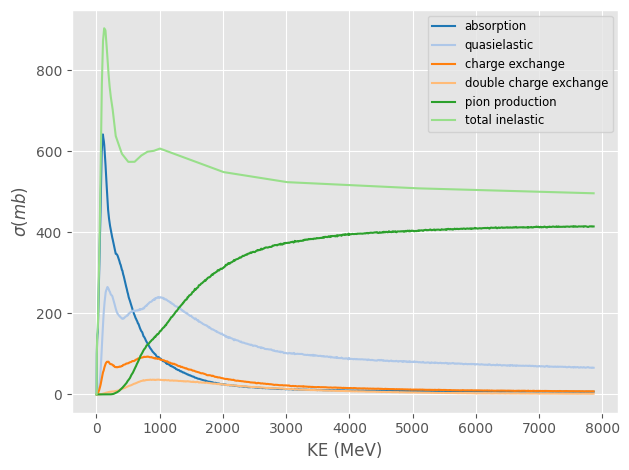

In [8]:
xs = cex_toy_generator.ModifyGeantXS(scale_factors = {"absorption" : 1, "charge_exchange" : 1, "pion_production" : 1, "double_charge_exchange" : 1, "quasielastic" : 1}, modified_PDFs = None)
xs.Plot("all")

In [ ]:
def NormalisationSystematic(data_config : dict, norms = [0.8, 1.2], plot : bool = False):
    x = args.energy_slices.pos[:-1] - args.energy_slices.width / 2

    exclusive_proc = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    cvs = {}
    true_cvs = {}
    for target in exclusive_proc:
        print(f"{target=}")
        scales = {k : 1 for k in ['absorption', 'quasielastic', 'charge_exchange', 'double_charge_exchange', 'pion_production']}
        xs = {}
        xs_true = {}
        for i in norms:
            if i == 1:
                config = {k : v for k,v in data_config.items()}
            else:
                if target == "single_pion_production":
                    scales["quasielastic"] = i
                    scales["double_charge_exchange"] = i
                else:
                    scales[target] = i
                config = cex_fit_studies.CreateConfigNormalisation(scales, data_config)
            ai = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.run(config)))
            
            if plot is True:
                out = f"test/normalisation_systematic/{target}/"
                cross_section.os.makedirs(out, exist_ok = True)
                book = Plots.PlotBook(f"{out}plots_{i}")
            else:
                book = None

            xs[i] = Analyse(ai, model, args, args.energy_slices, None, book)
            if plot is True:
                book.close()
                Plots.plt.close("all")
            xs_sim_mod = cex_toy_generator.ModifyGeantXS(scale_factors = config["pdf_scale_factors"])

            if args.fit["regions"]:
                xs_true[i] = {k : xs_sim_mod.GetInterpolatedCurve(k)(x) for k in exclusive_proc}
            else:
                xs_true[i] = xs_sim_mod.GetInterpolatedCurve(args.signal_process)(x)
        cvs[target] = xs
        true_cvs[target] = xs_true
    return cvs, true_cvs

norm_sys = cex_systematics.NormalisationSystematic(args, model, toy_config_nominal)
results = norm_sys.Evaluate([0.8, 1.2], 3)

In [125]:
cross_section.SaveObject("test/normsys.dill", results)

In [7]:
results = cross_section.LoadObject("test/normsys.dill")

In [8]:

cex_systematics.NormalisationSystematic.AverageResults(results)
results

# [i["absorption"][0] for i in results["cv"]["absorption"][0.8]]
# results["cv"]["absorption"][0.8][0]["absorption"][1]

{'cv': {'absorption': {0.8: {'absorption': [array([ 9.44834748, 33.56124138, 40.32101798, 37.84561199]),
     array([16.38711952, 18.20546442, 21.72065896, 25.51652612])],
    'charge_exchange': [array([49.16546156, 43.29942692, 69.42098407, 60.98705309]),
     array([29.96799619, 13.1404313 , 17.05268163, 25.9400561 ])],
    'single_pion_production': [array([175.05076717, 204.42520789, 231.29134505, 271.81152294]),
     array([19.08398228, 12.27613192, 15.81716981, 27.94927401])],
    'pion_production': [array([294.22954666, 271.2817223 , 255.01699042, 220.34813011]),
     array([25.69188431, 11.96775608, 15.02421093, 23.94002647])]},
   1.2: {'absorption': [array([20.36740516, 44.91028388, 55.86428654, 57.2161717 ]),
     array([15.60647282, 15.86514388, 19.66331881, 23.51411363])],
    'charge_exchange': [array([43.85112231, 37.76636201, 63.06895268, 64.21913531]),
     array([32.02573783, 13.29205978, 17.22304901, 27.54694943])],
    'single_pion_production': [array([175.35463621, 

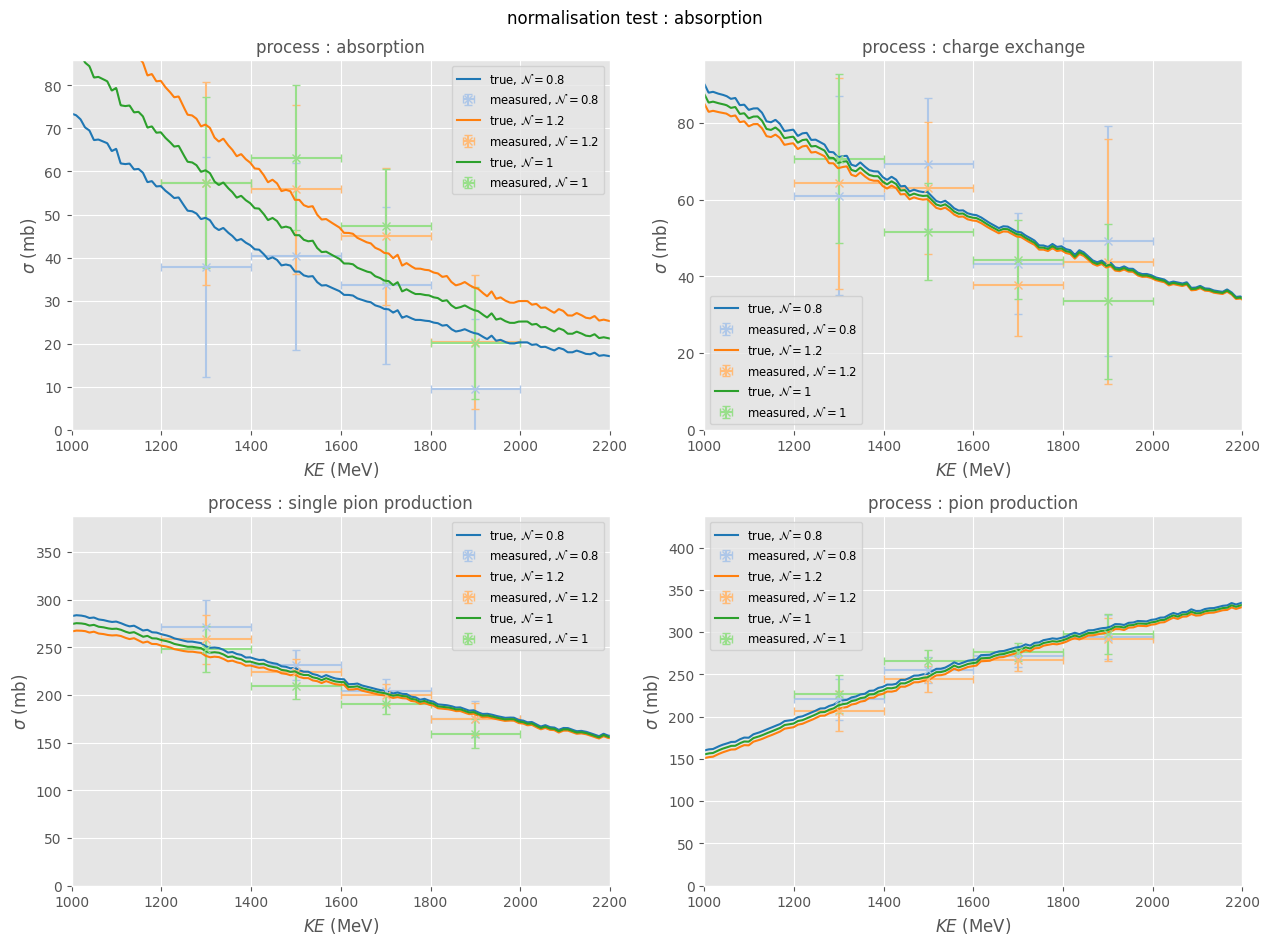

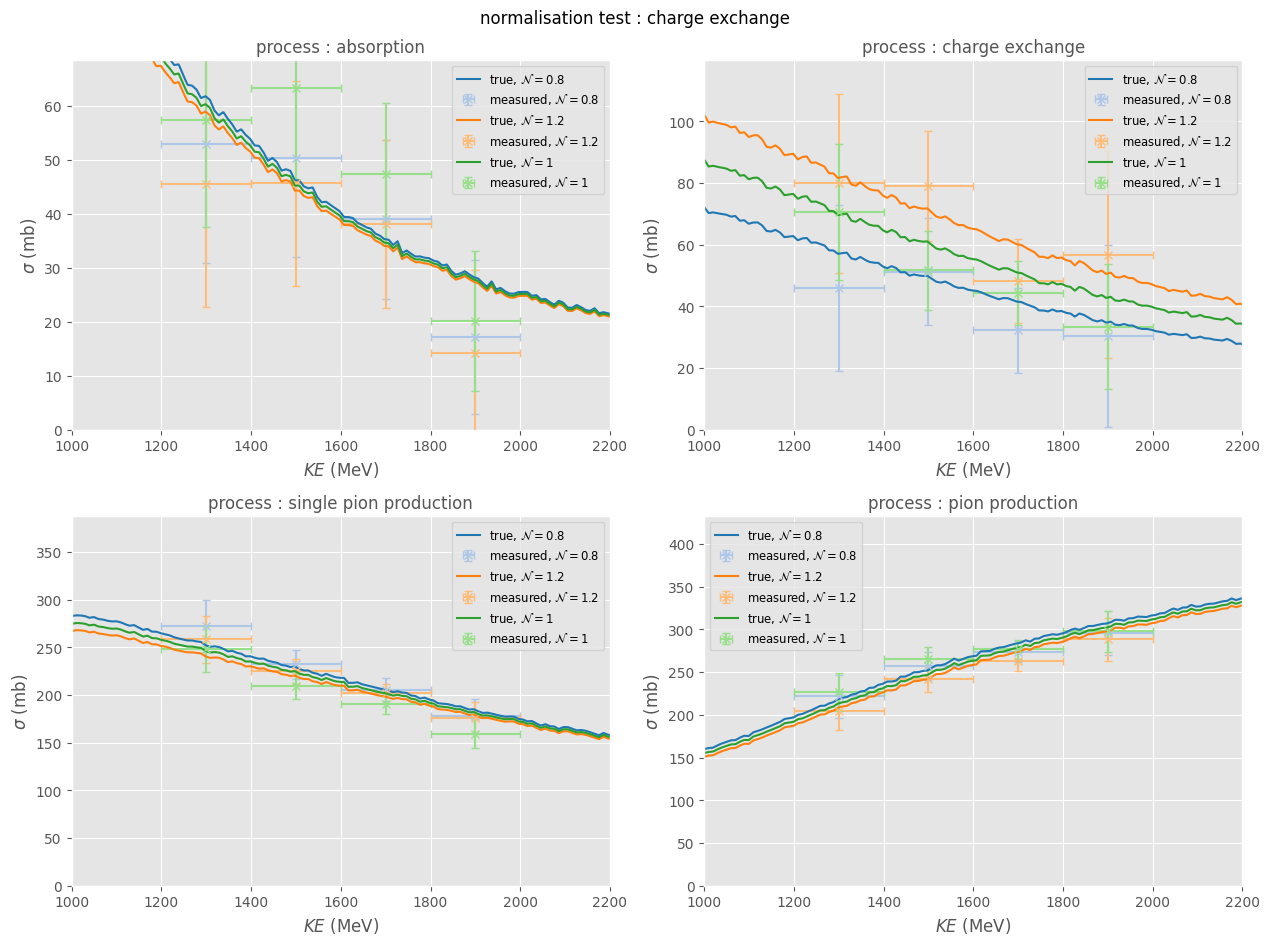

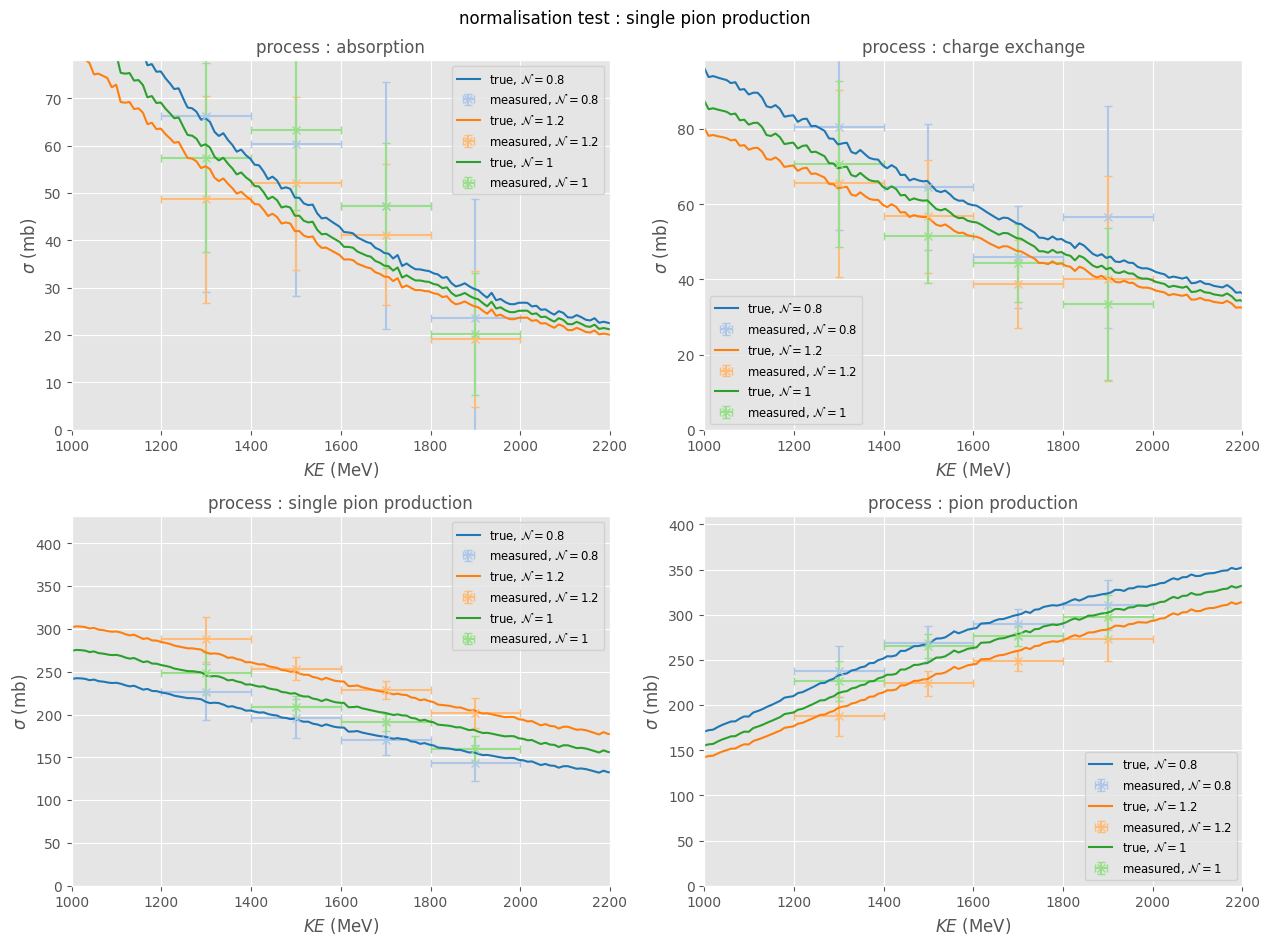

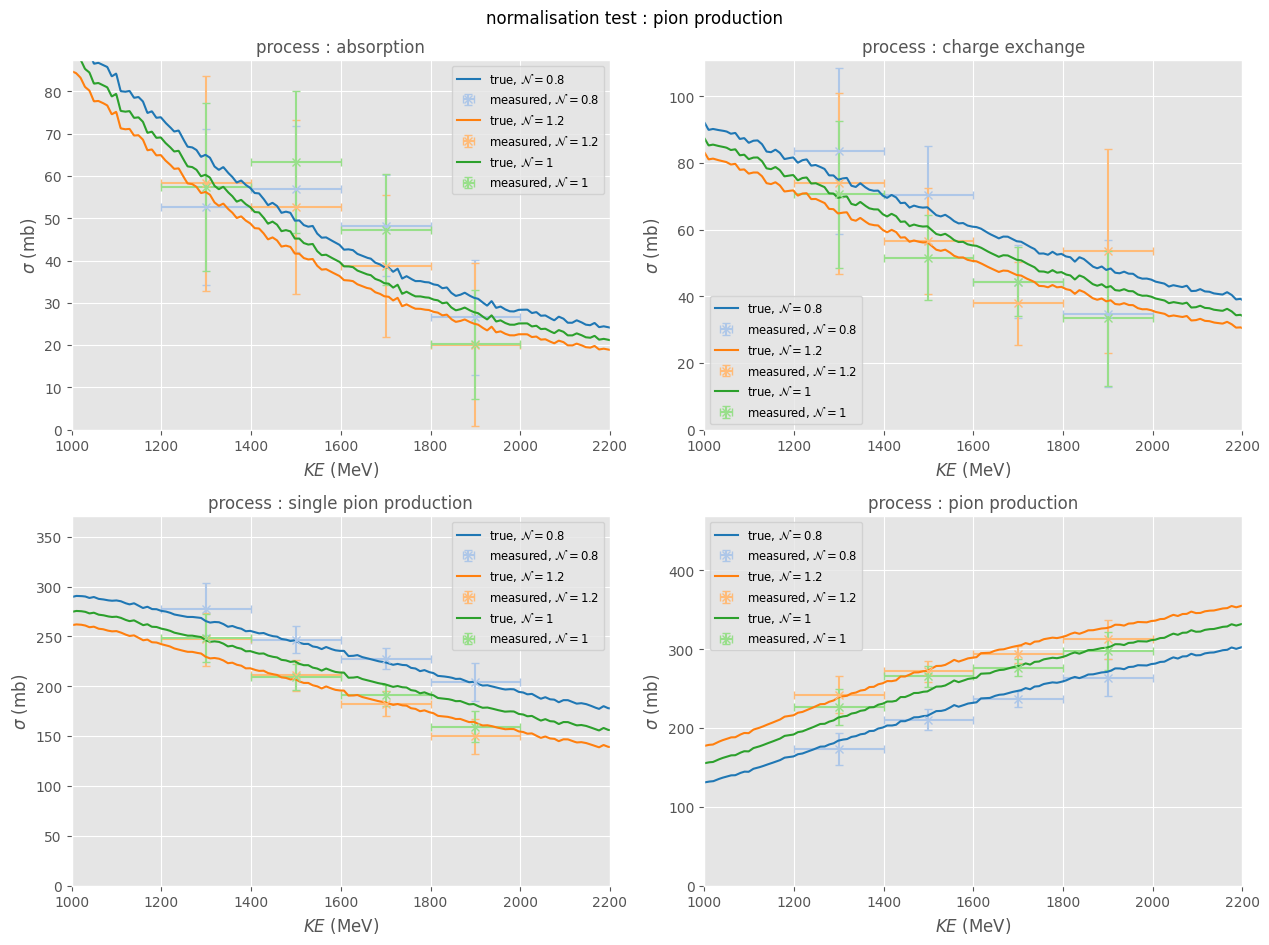

In [129]:
cex_systematics.NormalisationSystematic.PlotNormalisationTestResults(results, args, xs_nominal)

In [34]:
book = Plots.PlotBook("normalisation_sys.pdf", False)

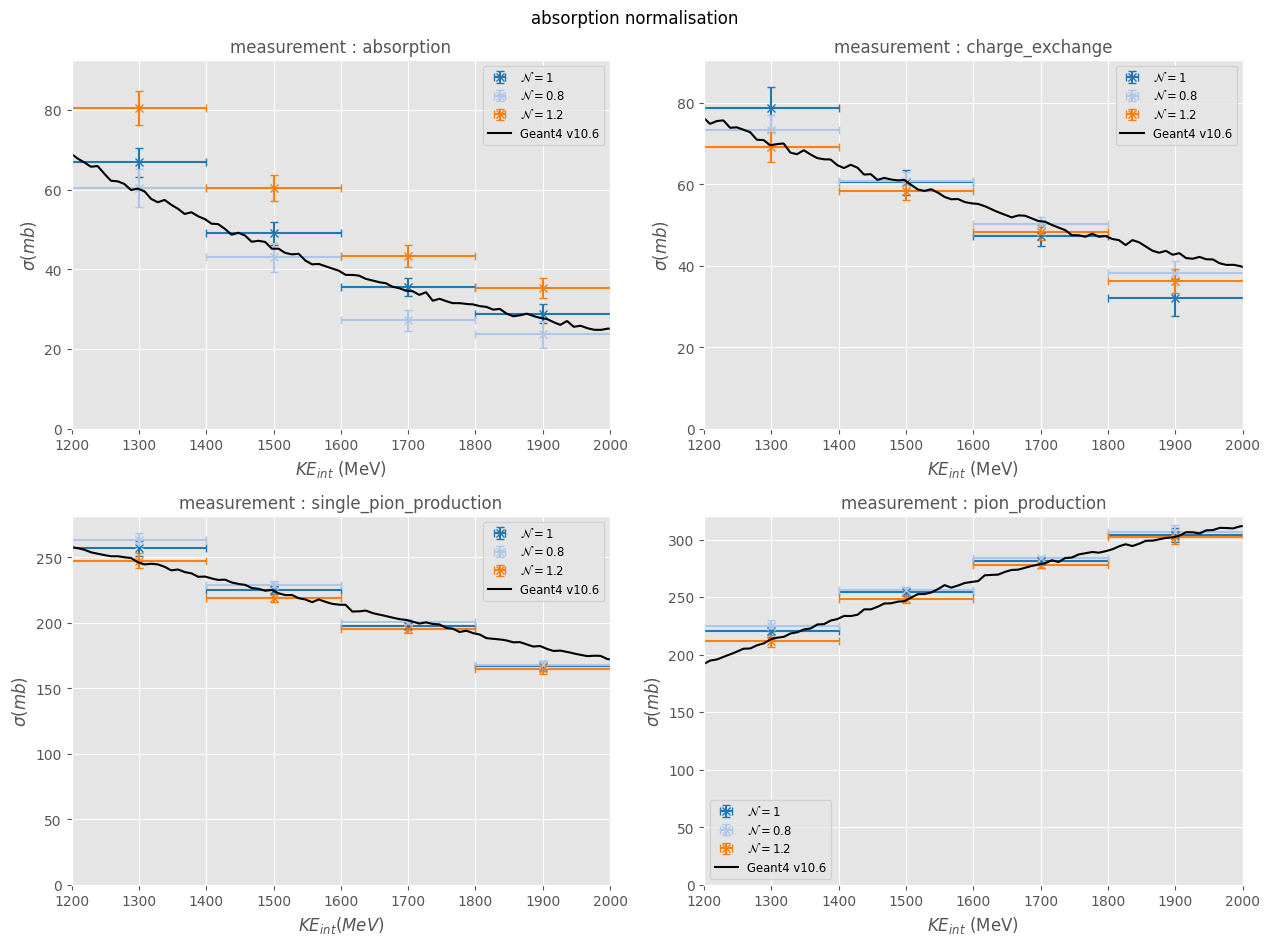

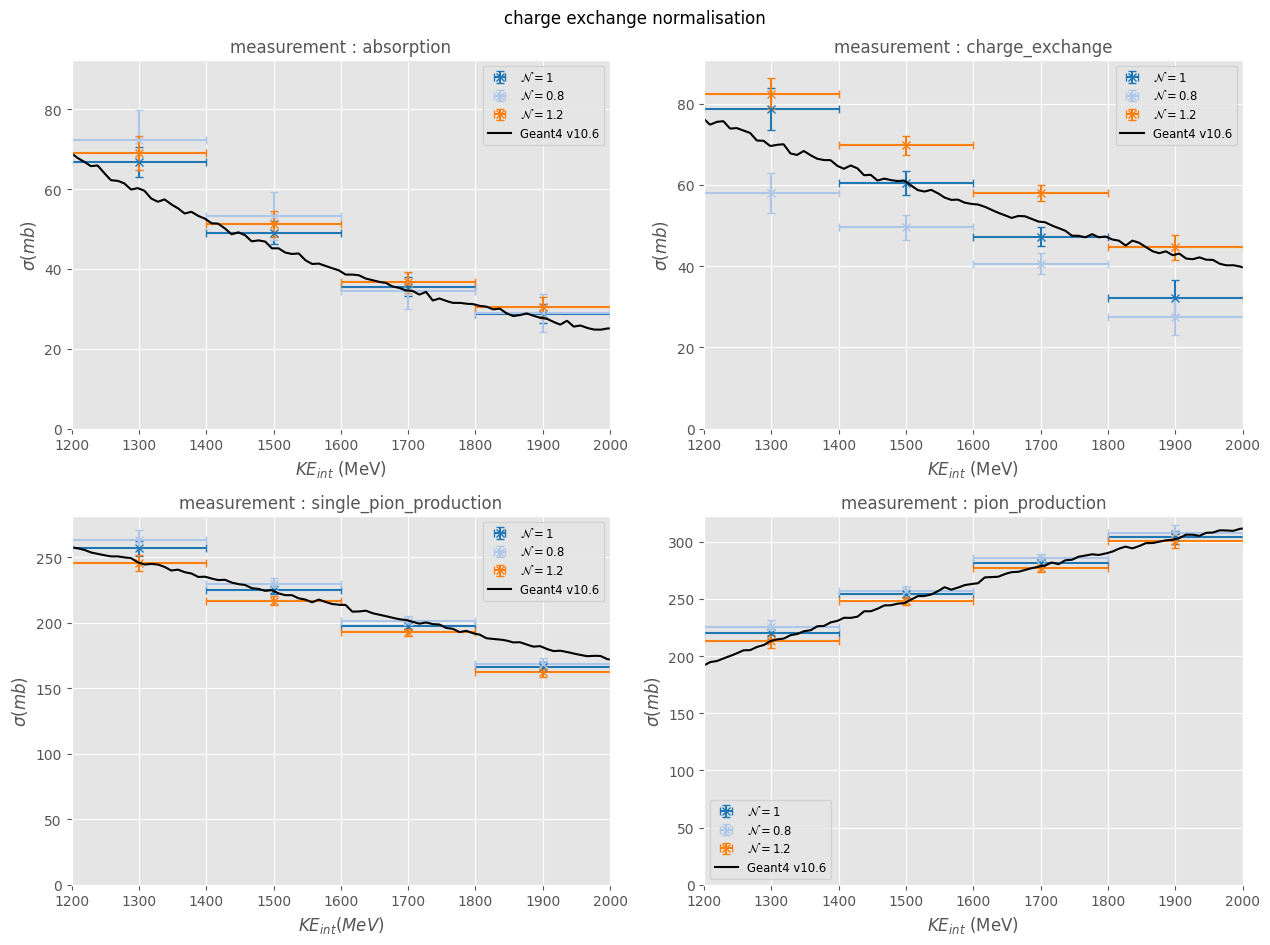

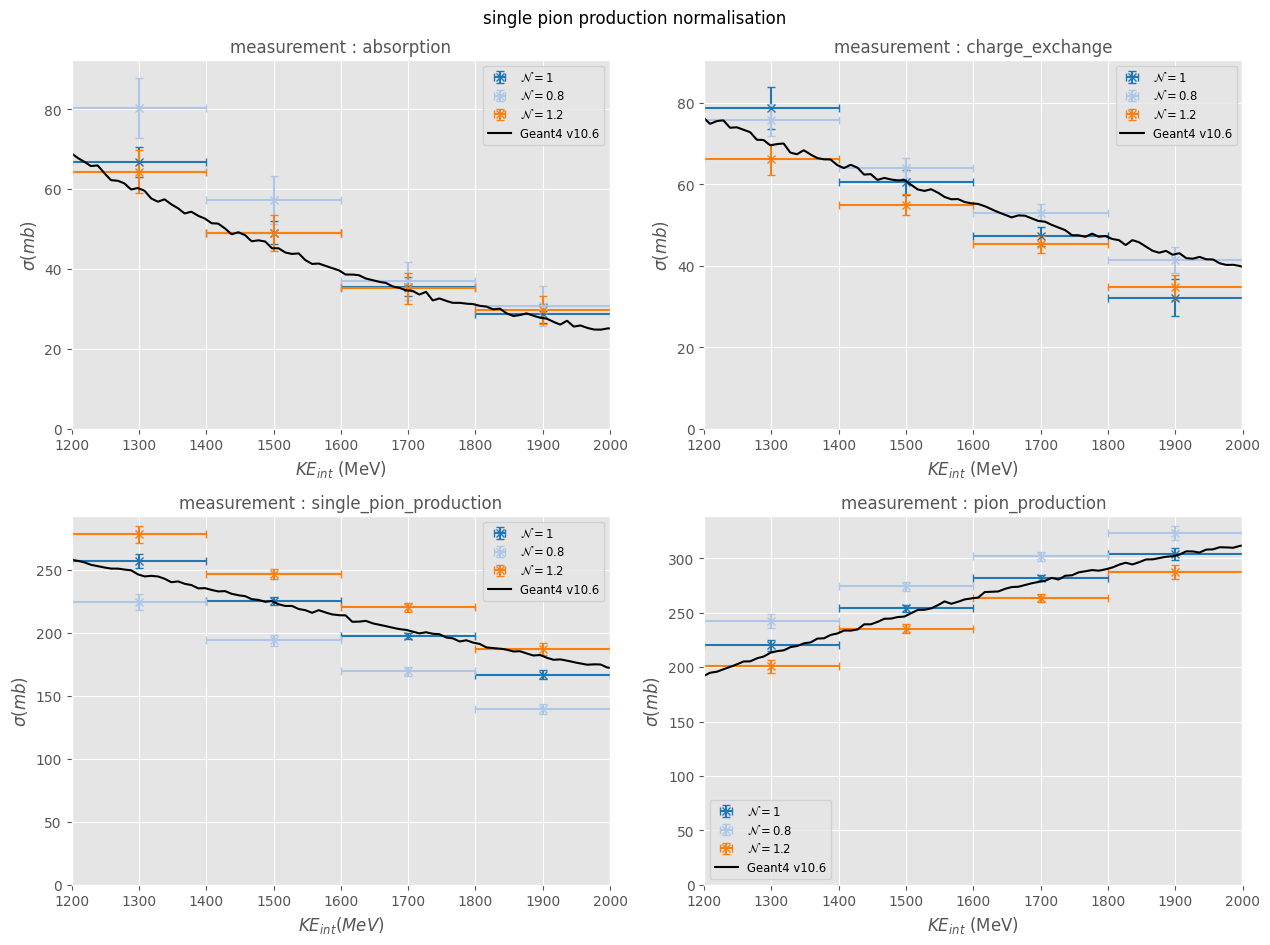

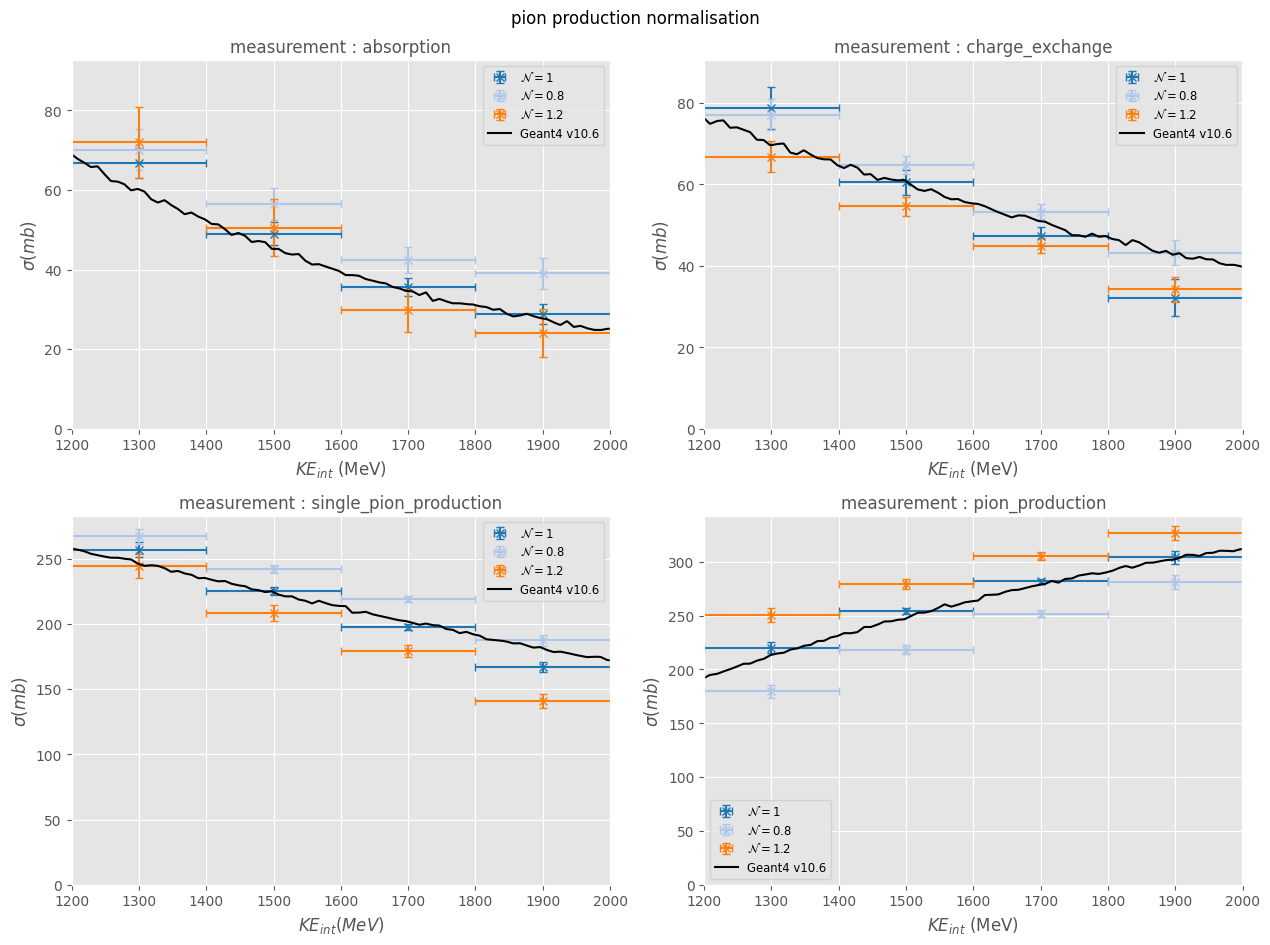

In [35]:
xs_sim = cross_section.GeantCrossSections()

for r in results[0]:
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        cross_section.PlotXSComparison({"$\mathcal{N}=1$" : xs_nominal[p], "$\mathcal{N}=0.8$" : results[0][r][0.8][p], "$\mathcal{N}=1.2$" : results[0][r][1.2][p]}, args.energy_slices, p, title = f"measurement : {p}", newFigure = False, chi2 = False, simulation_label = "Geant4 v10.6")
        
        if p == "single_pion_production":
            gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
        else:
            gxs = getattr(xs_sim, p)

        # Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
        Plots.plt.legend()
    Plots.plt.suptitle(f"{cross_section.remove_(r)} normalisation")
    Plots.plt.tight_layout()
    book.Save()

In [9]:
sys_err = cex_systematics.NormalisationSystematic.CalculateSysErr(results)

In [131]:
norm_sys_qs = cex_systematics.NormalisationSystematic.TotalSysQS(sys_err)

norm_sys_max = cex_systematics.NormalisationSystematic.TotalSysMax(sys_err)

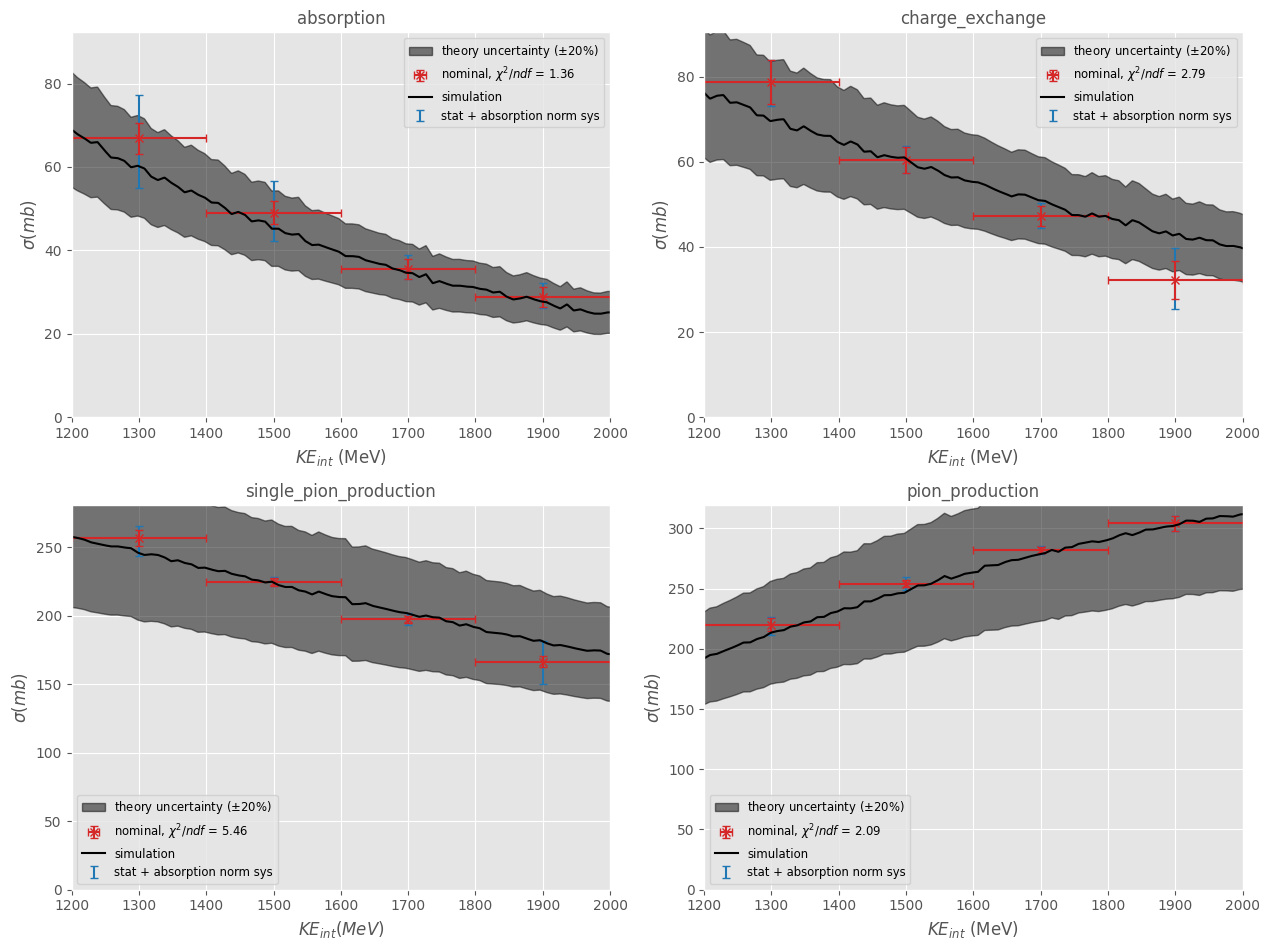

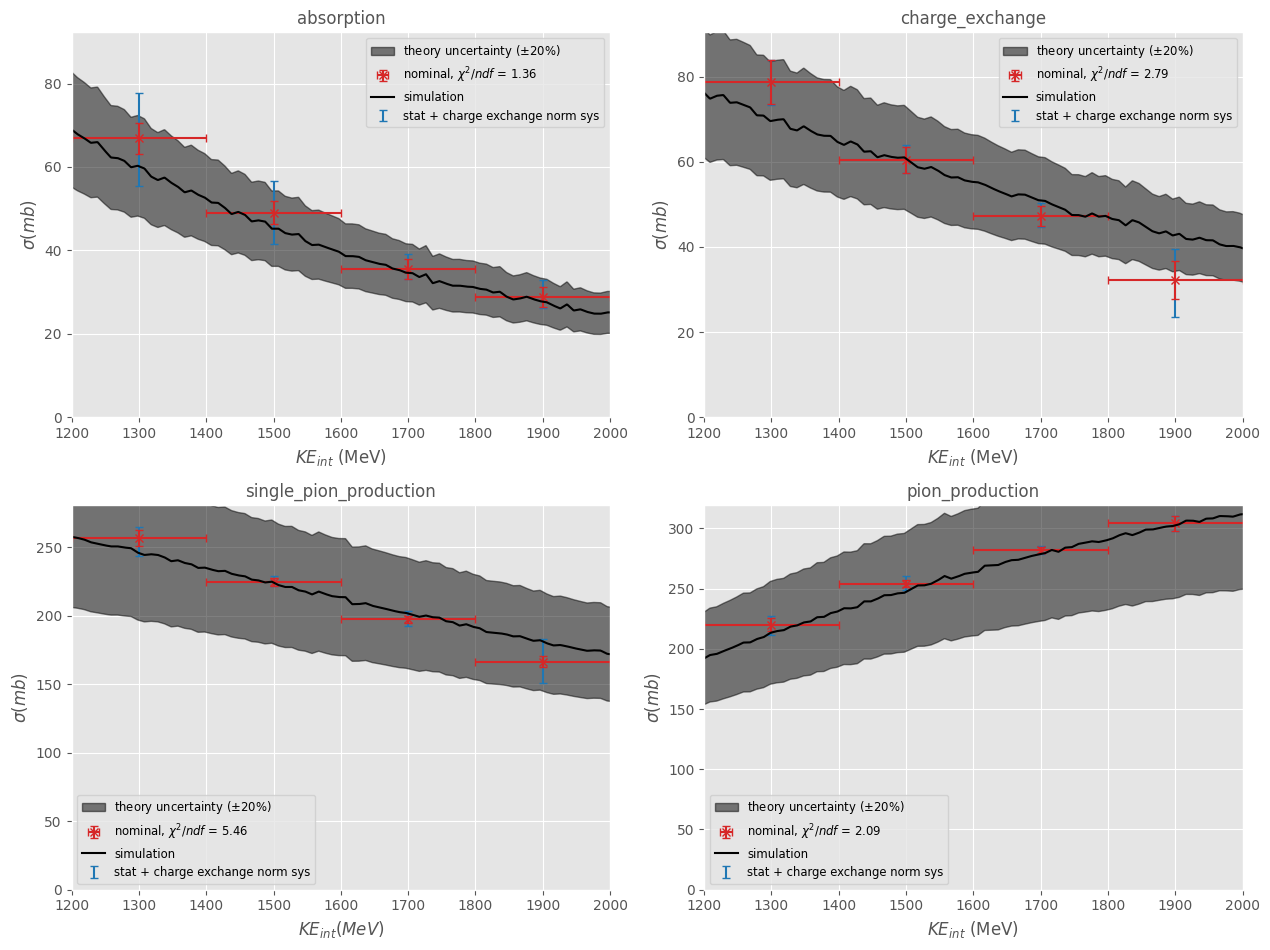

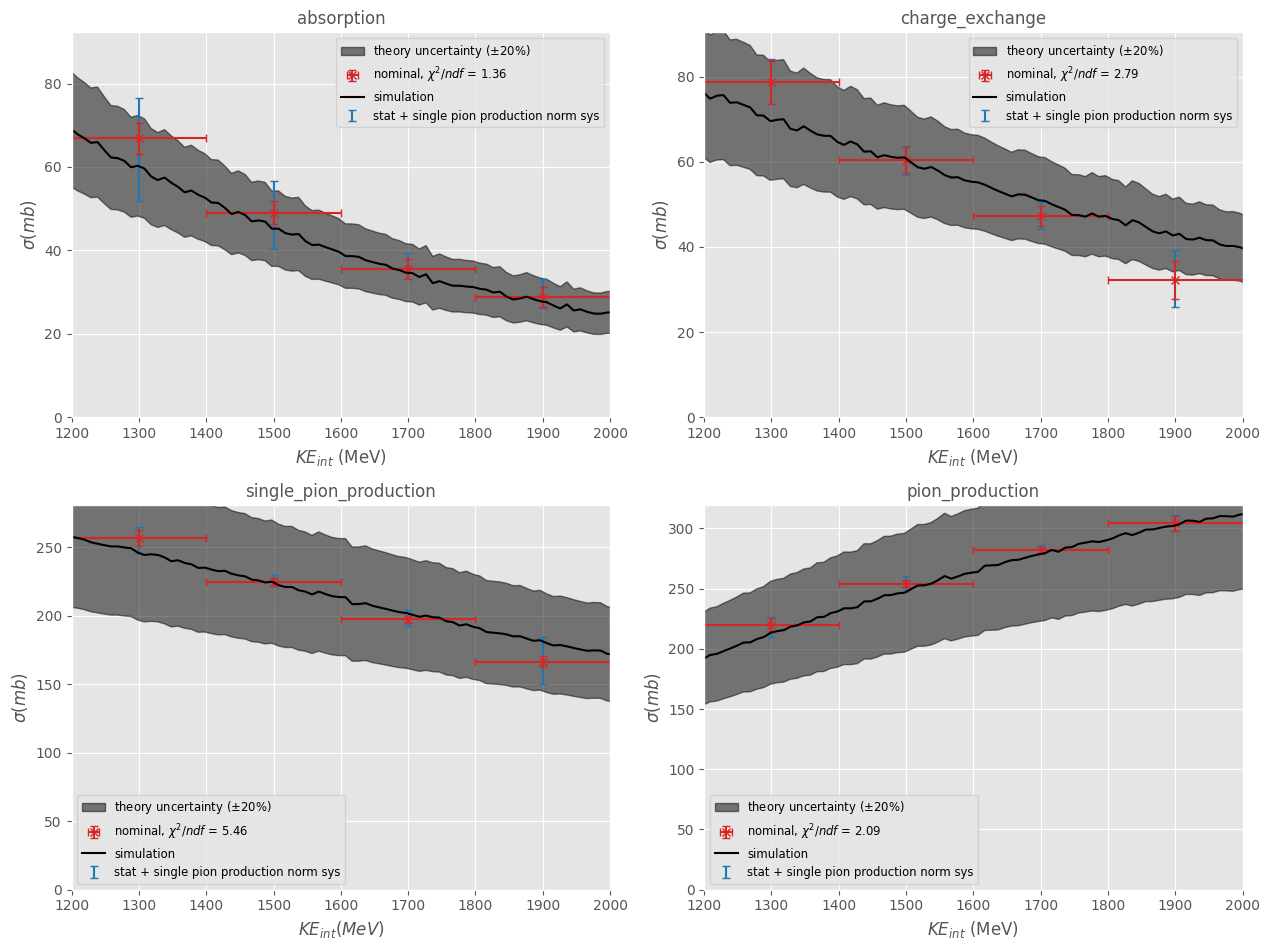

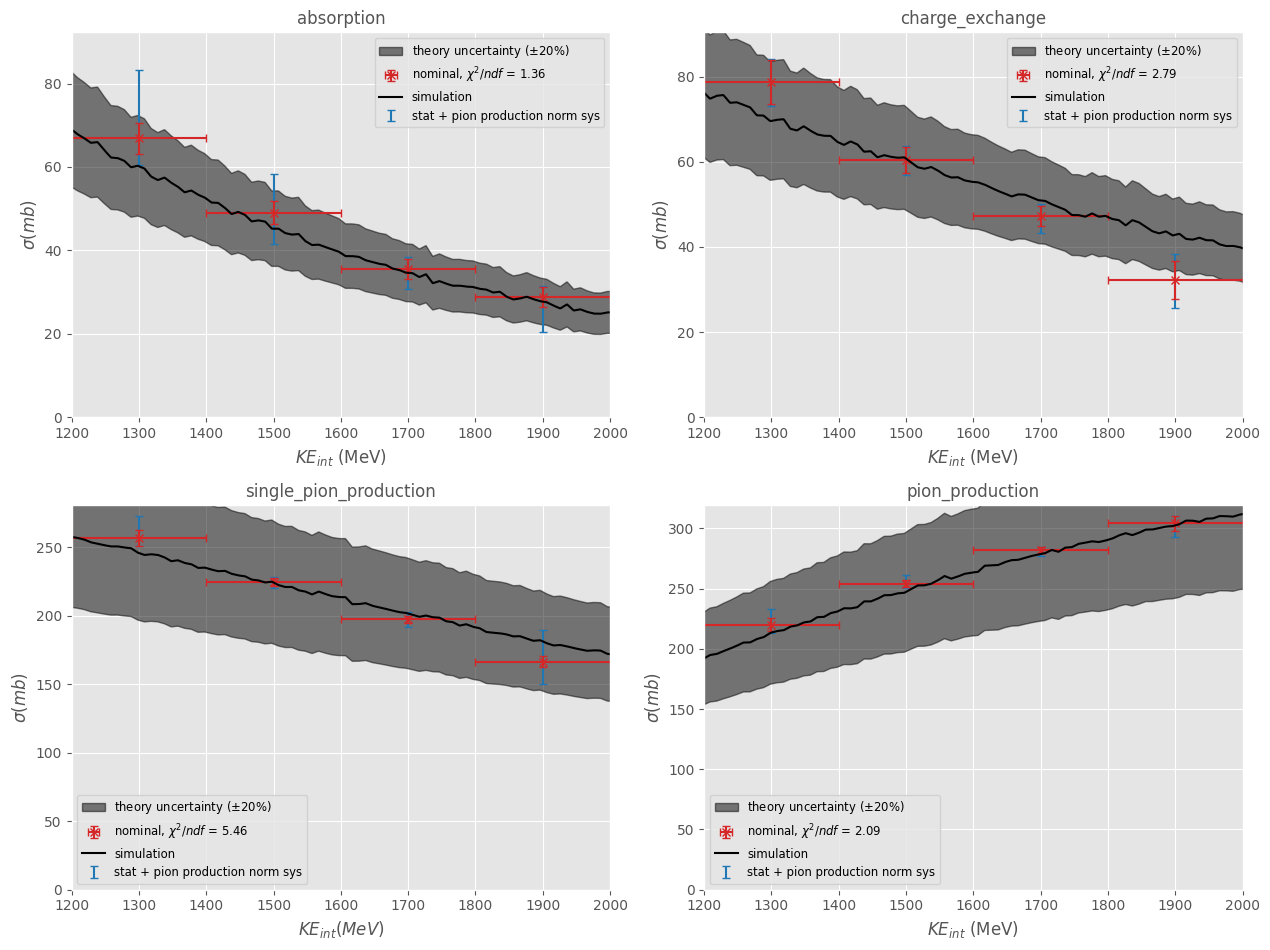

In [38]:
for r in results[0]:    
    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        total_err_low = cross_section.quadsum([xs_nominal[p][1], sys_err["low"][r][p]], 0)
        total_err_high = cross_section.quadsum([xs_nominal[p][1], sys_err["high"][r][p]], 0)

        cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
        x = args.energy_slices.pos[:-1] - args.energy_slices.width/2
        Plots.Plot(x, xs_nominal[p][0], yerr = [total_err_low, total_err_high], linestyle = "", marker = "", label = f"stat + {cross_section.remove_(r)} norm sys", newFigure = False, zorder = 1.5)

        if p == "single_pion_production":
            gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
        else:
            gxs = getattr(xs_sim, p)

        Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
        Plots.plt.legend()
        book.Save()


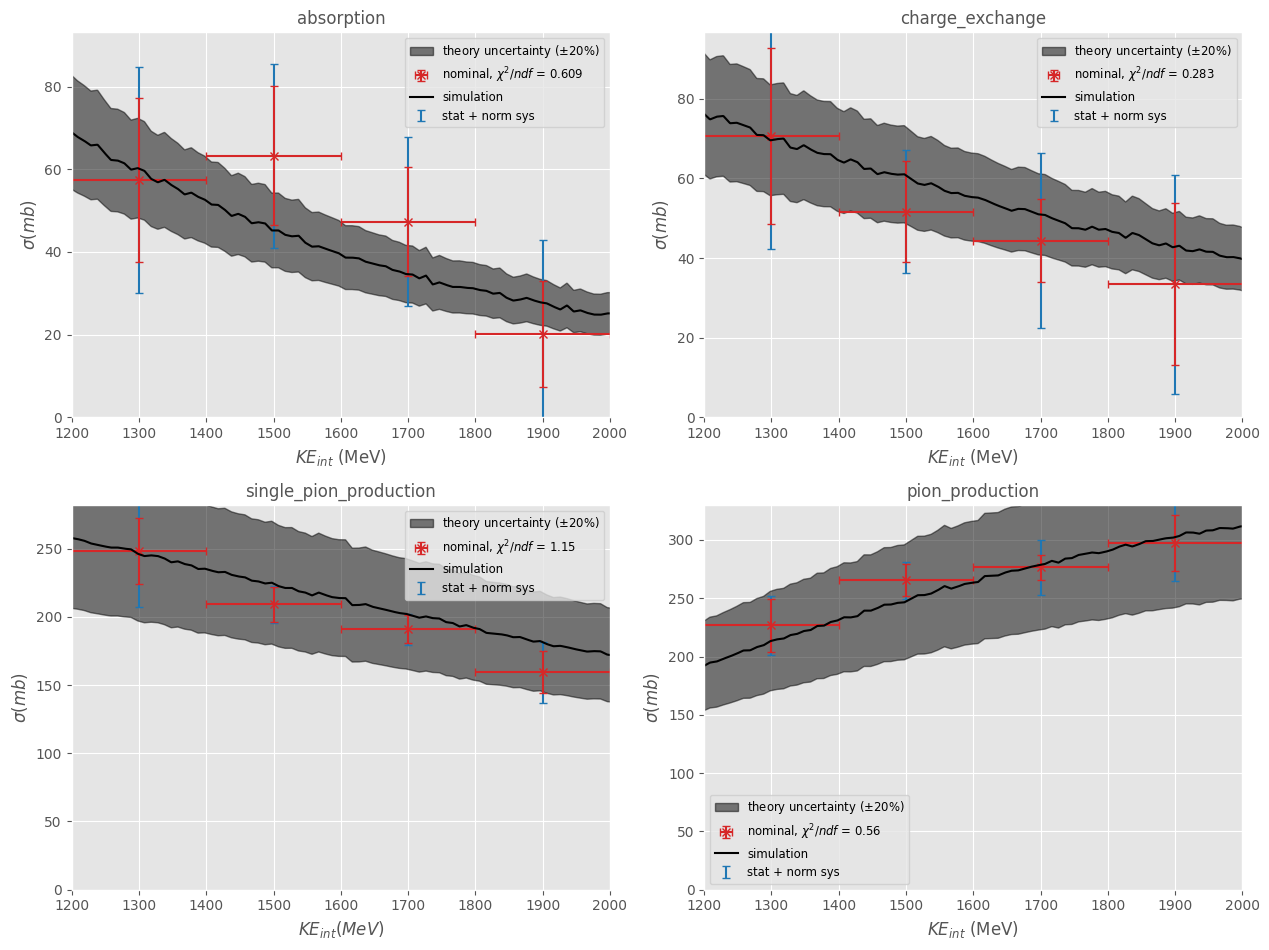

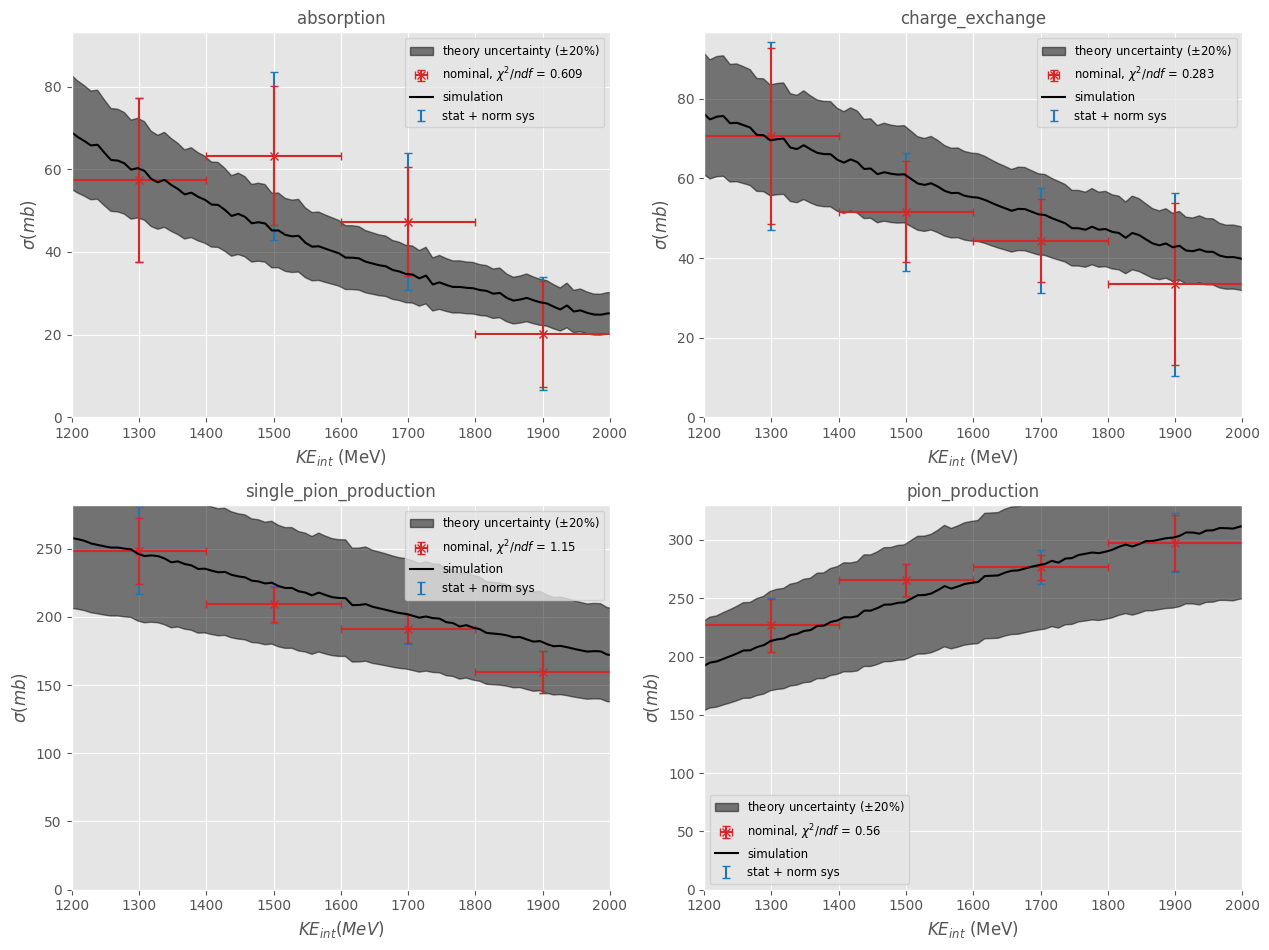

In [132]:
xs_sim = cross_section.GeantCrossSections()
for _, p in Plots.IterMultiPlot(norm_sys_qs):
    total_err = [cross_section.quadsum([xs_nominal[p][1], norm_sys_qs[p][0]], 0) for i in range(2)]

    x = args.energy_slices.pos[:-1] - args.energy_slices.width/2

    cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
    Plots.Plot(x, xs_nominal[p][0], yerr = total_err, linestyle = "", marker = "", label = f"stat + norm sys", newFigure = False, zorder = 1.5)

    if p == "single_pion_production":
        gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
    else:
        gxs = getattr(xs_sim, p)

    Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

for _, p in Plots.IterMultiPlot(norm_sys_max):
    total_err = [cross_section.quadsum([xs_nominal[p][1], norm_sys_max[p][0]], 0) for i in range(2)]

    cross_section.PlotXSComparison({"nominal" : xs_nominal[p]}, args.energy_slices, p, {"nominal" : "C6"}, xs_sim_color = "k", title = p, newFigure = False)
    Plots.Plot(x, xs_nominal[p][0], yerr = total_err, linestyle = "", marker = "", label = f"stat + norm sys", newFigure = False, zorder = 1.5)

    if p == "single_pion_production":
        gxs = getattr(xs_sim, "double_charge_exchange") + getattr(xs_sim, "quasielastic")
    else:
        gxs = getattr(xs_sim, p)

    Plots.plt.fill_between(xs_sim.KE, gxs * 0.8, gxs * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
    Plots.plt.legend()
    book.Save()

# norm_sys = []
# for r in results[0]:
#     err_low = SysErr(results[1][r][1.2], results[0][r][1.2][0])
#     err_high = SysErr(results[1][r][0.8], results[0][r][0.8][0])

#     sys_err_low = np.max([err_low[0], err_high[0]], 0)
#     sys_err_high = np.max([err_low[1], err_high[1]], 0)

#     norm_sys.append([sys_err_low, sys_err_high])

# total_norm_sys = cross_section.quadsum(norm_sys, 0)
# total_sys = [cross_section.quadsum([xs_nominal[1], total_norm_sys[0]], 0), cross_section.quadsum([xs_nominal[1], total_norm_sys[1]], 0)]

# cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
# Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = total_sys, linestyle = "", marker = "", label = f"stat + sys", newFigure = False, zorder = 1.5)
# Plots.plt.fill_between(xs_sim.KE, getattr(xs_sim, args.signal_process) * 0.8, getattr(xs_sim, args.signal_process) * 1.2, color = "k", alpha = 0.5, label = "theory uncertainty ($\pm20\%$)", zorder = 1)
# Plots.plt.legend()

# book.Save()

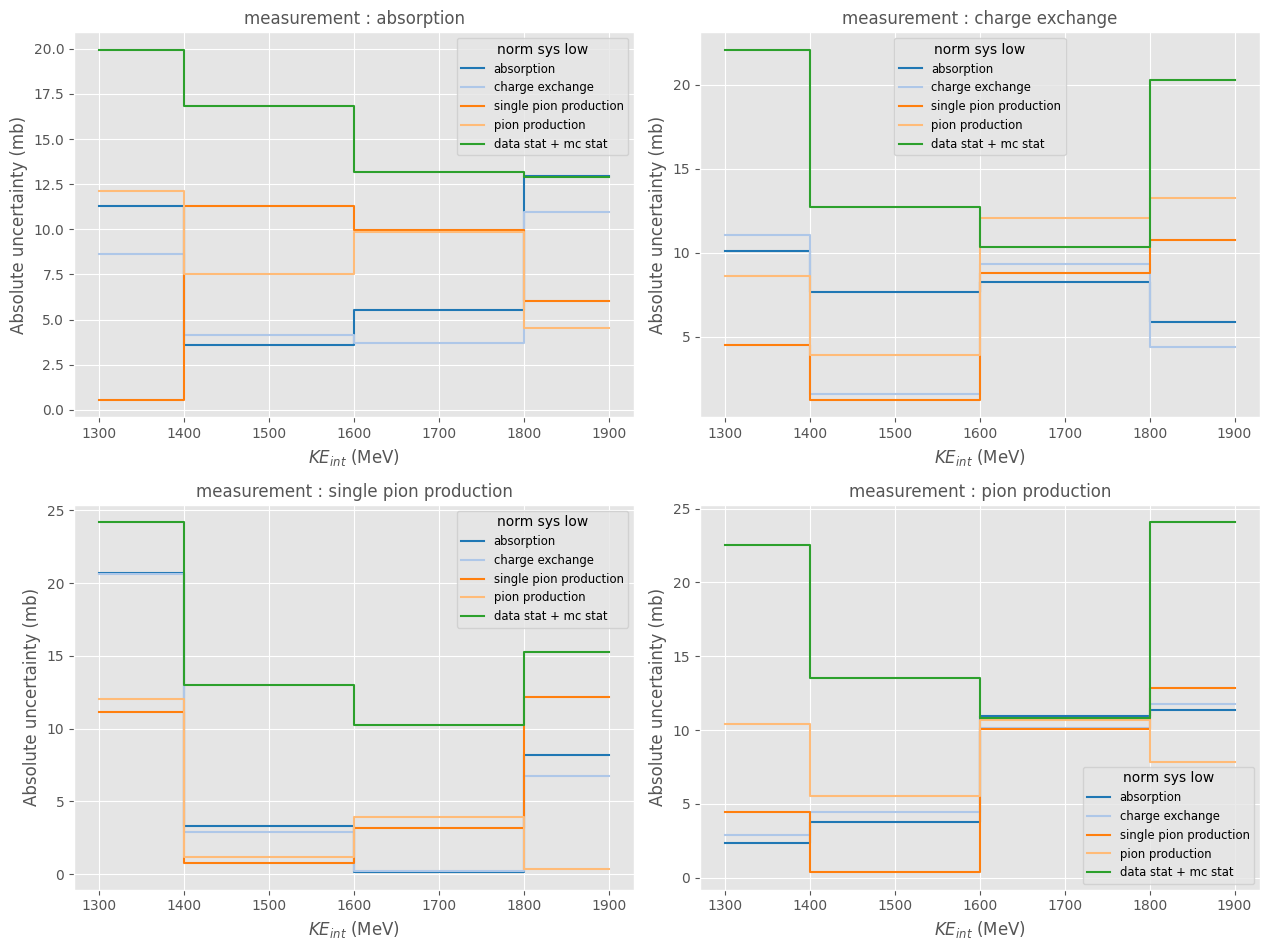

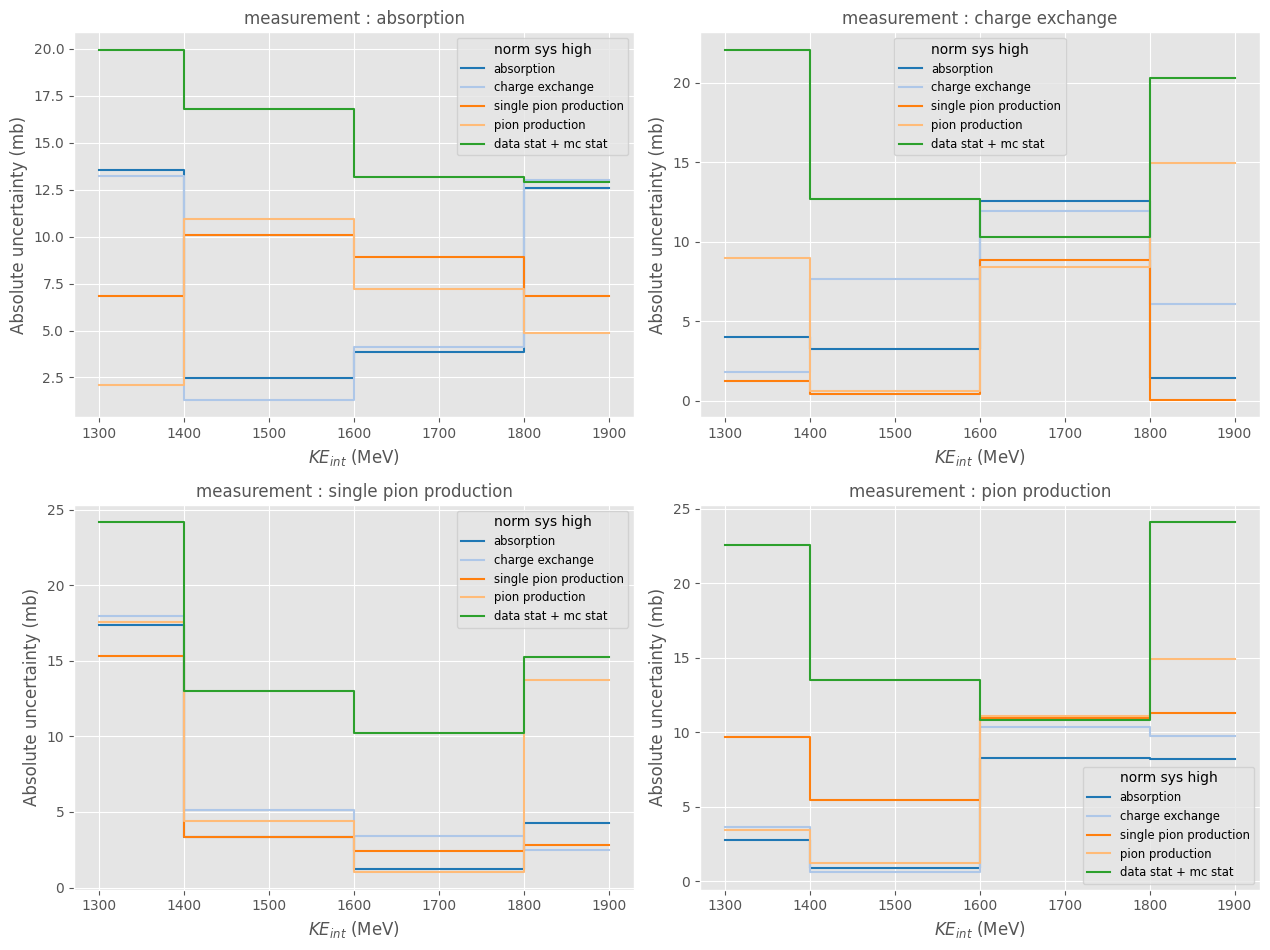

In [133]:
def PlotSys(sys, name : str):
    x = args.energy_slices.pos[:-1] - args.energy_slices.width/2

    for _, p in Plots.IterMultiPlot(analysis_input_nominal.exclusive_process):
        for r in sys:
            Plots.Plot(x, abs(sys[r][p]), label = cross_section.remove_(r), title = f"measurement : {cross_section.remove_(p)}", xlabel = "$KE_{int}$ (MeV)", ylabel = "Absolute uncertainty (mb)", newFigure = False, style = "step")
        Plots.Plot(x, xs_nominal[p][1], label = "data stat + mc stat", newFigure = False, style = "step")
        Plots.plt.legend(title = name)

PlotSys(sys_err["low"], "norm sys low")
PlotSys(sys_err["high"], "norm sys high")

In [27]:
book.close()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


# Data analysis systematics

In [23]:
from apps import cex_analysis_input
args_copy = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/analysis_config.json"))

In [25]:
upl = cex_systematics.UpstreamCorrectionSystematic(args_copy)
upl.CreateNewAIs("test/")

'BeamPionSelection' executed in 0.0208s

'RegionSelection' executed in 7.7464s

'RecoDepositedEnergy' executed in 10.4030s

'RecoDepositedEnergy' executed in 9.7304s

'BeamPionSelection' executed in 0.0569s

'RegionSelection' executed in 5.7713s

'RecoDepositedEnergy' executed in 42.1434s

'BeamPionSelection' executed in 0.0189s

'RegionSelection' executed in 7.9035s

'RecoDepositedEnergy' executed in 8.5539s

'RecoDepositedEnergy' executed in 10.1788s

'BeamPionSelection' executed in 0.0548s

'RegionSelection' executed in 5.9988s

'RecoDepositedEnergy' executed in 30.7855s

In [7]:
def CreateBeamRweightAIs():
    args_copy = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/analysis_config.json"))
    brw = {
        "low" : {k : v["value"] - v["error"] for k, v in args_copy.beam_reweight_params.items()},
        "high" : {k : v["value"] + v["error"] for k, v in args_copy.beam_reweight_params.items()}
    }
    for k, v in brw:
        args_copy.upstream_loss_correction_params["value"] = v
        args.out = f"test/upstream_loss_1_sigma_{k}/"
        cex_analysis_input.main(args)
    return

In [26]:
ai_low = cross_section.AnalysisInput.FromFile("test/upstream_loss_1_sigma_low/analysis_input/analysis_input_mc_selected.dill")
ai_high = cross_section.AnalysisInput.FromFile("test/upstream_loss_1_sigma_high/analysis_input/analysis_input_mc_selected.dill")
ai_nominal = cross_section.AnalysisInput.FromFile("work/2023/analysis_2GeV_new_pfo_selection/analysis_input/analysis_input_mc_selected.dill")

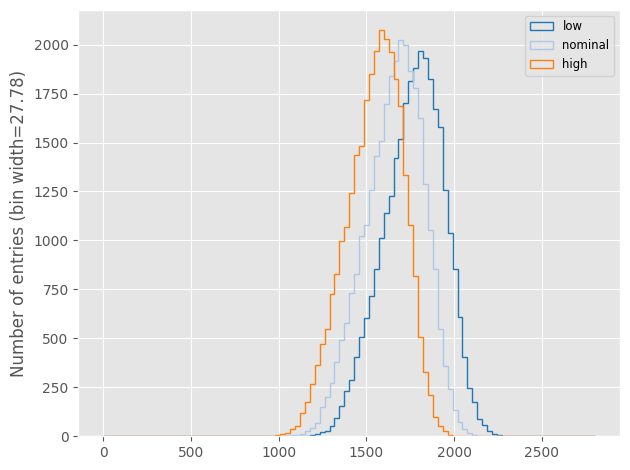

In [27]:
Plots.PlotHistComparison([ai_low.KE_int_reco, ai_nominal.KE_int_reco, ai_high.KE_int_reco], labels = ["low", "nominal", "high"], density = False)

In [28]:
upl.RunAnalysis("test/")

loading Data and MC

analysing pdsp

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-14921.06986766])


fit_values.bestfit=array([2.1709865 , 2.85779509, 1.44928178, 3.08614853, 0.99999902,
       0.99998237, 1.0000034 , 0.99999524])

init
Iteration 1: ts = 0.0089, ts_stopping = 0.01
int
Iteration 1: ts = 0.0084, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.1250, ts_stopping = 0.01
Iteration 2: ts = 0.0622, ts_stopping = 0.01
Iteration 3: ts = 0.0290, ts_stopping = 0.01
Iteration 4: ts = 0.0180, ts_stopping = 0.01
Iteration 5: ts = 0.0132, ts_stopping = 0.01
Iteration 6: ts = 0.0106, ts_stopping = 0.01
Iteration 7: ts = 0.0090, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0446, ts_stopping = 0.01
Iteration 2: ts = 0.0260, ts_stopping = 0.01
Iteration 3: ts = 0.0144, ts_stopping = 0.01
Iteration 4: ts = 0.0076, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.1025, ts_stopping = 0.01
Iteration 2: ts = 0.0583, ts_stopping = 0.01
Iteration 3: ts = 0.0306, ts_stopping = 0.01
Iteration 4: ts = 0.0163, ts_stopping = 0.01
Iteration 5: ts = 0.0113, ts_stopping = 0.01
Iteration 6: ts = 0.0087, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0146, ts_stopping = 0.01
Iteration 2: ts = 0.0081,

process={'absorption': (array([ 10.5168546 ,  33.11097383,  61.87478766, 108.51492112]), array([ 9.79447407, 
11.52596492, 17.59004576, 34.63710123])), 'charge_exchange': (array([ 37.61516774,  51.64832323,  86.97201205, 
133.27845448]), array([ 6.22313921,  4.782798  , 10.15178497, 31.27279859])), 'single_pion_production': (array([ 
50.46966526, 108.16700912, 193.77221657, 317.54919393]), array([13.66444164, 13.0059188 , 25.16880062, 
66.90658947])), 'pion_production': (array([387.19319027, 355.81870262, 275.70097466, 247.87660678]), 
array([21.68096898, 12.73721521, 16.60628715, 44.14383711]))}

loading Data and MC

analysing pdsp

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-14921.06986766])


fit_values.bestfit=array([2.17098648, 2.85779509, 1.44928178, 3.08614853, 0.99999903,
       0.99998237, 1.0000034 , 0.99999524])

init
Iteration 1: ts = 0.0111, ts_stopping = 0.01
Iteration 2: ts = 0.0097, ts_stopping = 0.01
int
Iteration 1: ts = 0.0095, ts_stopping = 0.01
absorption
Iteration 1: ts = 0.1253, ts_stopping = 0.01
Iteration 2: ts = 0.0666, ts_stopping = 0.01
Iteration 3: ts = 0.0351, ts_stopping = 0.01
Iteration 4: ts = 0.0196, ts_stopping = 0.01
Iteration 5: ts = 0.0119, ts_stopping = 0.01
Iteration 6: ts = 0.0078, ts_stopping = 0.01
charge_exchange
Iteration 1: ts = 0.0434, ts_stopping = 0.01
Iteration 2: ts = 0.0257, ts_stopping = 0.01
Iteration 3: ts = 0.0145, ts_stopping = 0.01
Iteration 4: ts = 0.0078, ts_stopping = 0.01
single_pion_production
Iteration 1: ts = 0.1006, ts_stopping = 0.01
Iteration 2: ts = 0.0583, ts_stopping = 0.01
Iteration 3: ts = 0.0320, ts_stopping = 0.01
Iteration 4: ts = 0.0176, ts_stopping = 0.01
Iteration 5: ts = 0.0100, ts_stopping = 0.01
Iteration 6: ts = 0.0063, ts_stopping = 0.01
pion_production
Iteration 1: ts = 0.0162, ts_stopping = 0.01
Iteration 2: ts = 0.0097,

process={'absorption': (array([ 12.14266726,  24.1384664 ,  69.21763329, 100.76885018]), array([17.74475957,  
8.09713177, 16.48500927, 33.47174014])), 'charge_exchange': (array([ 27.25023054,  54.27477869,  87.91219053, 
128.22187152]), array([ 7.26725255,  5.23324587,  9.99824666, 32.28289446])), 'single_pion_production': (array([ 
53.27223393, 102.82902583, 202.59079875, 321.97794881]), array([24.07945503, 12.41457057, 24.4915567 , 74.0206716 
])), 'pion_production': (array([391.58215662, 352.73173593, 284.08641514, 250.15719191]), array([26.4194381 , 
14.45466409, 18.30626731, 50.6303139 ]))}

{'low': {'absorption': (array([ 10.5168546 ,  33.11097383,  61.87478766, 108.51492112]),
   array([ 9.79447407, 11.52596492, 17.59004576, 34.63710123])),
  'charge_exchange': (array([ 37.61516774,  51.64832323,  86.97201205, 133.27845448]),
   array([ 6.22313921,  4.782798  , 10.15178497, 31.27279859])),
  'single_pion_production': (array([ 50.46966526, 108.16700912, 193.77221657, 317.54919393]),
   array([13.66444164, 13.0059188 , 25.16880062, 66.90658947])),
  'pion_production': (array([387.19319027, 355.81870262, 275.70097466, 247.87660678]),
   array([21.68096898, 12.73721521, 16.60628715, 44.14383711]))},
 'high': {'absorption': (array([ 12.14266726,  24.1384664 ,  69.21763329, 100.76885018]),
   array([17.74475957,  8.09713177, 16.48500927, 33.47174014])),
  'charge_exchange': (array([ 27.25023054,  54.27477869,  87.91219053, 128.22187152]),
   array([ 7.26725255,  5.23324587,  9.99824666, 32.28289446])),
  'single_pion_production': (array([ 53.27223393, 102.82902583, 202.5907987

In [36]:
upl.CalculateSysError(xs)

{'absorption': array([0.81290633, 4.48625372, 3.67142281, 3.87303547]),
 'charge_exchange': array([5.1824686 , 1.31322773, 0.47008924, 2.52829148]),
 'single_pion_production': array([1.40128434, 2.66899165, 4.40929109, 2.21437744]),
 'pion_production': array([2.19448318, 1.54348334, 4.19272024, 1.14029256])}

# Plotting systematics

In [104]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/analysis_config.json"))

In [105]:
cv = cross_section.LoadObject("work/2023/analysis_2GeV_new_pfo_selection/measurement/xs.dill")["pdsp"]
print(cv)

{
    'absorption': (
        array([  0.2439712 ,  39.34807752,  49.23403351, 111.9130018 ]),
        array([ 4.87847486, 14.29853574, 14.13702538, 42.13325135])
    ),
    'charge_exchange': (
        array([ 4.61174657, 58.3567793 , 92.86561983, 82.30241564]),
        array([ 4.46941532,  8.50849259, 13.12952041, 31.33916911])
    ),
    'single_pion_production': (
        array([  3.85378099, 132.74128263, 164.98966971, 267.87113074]),
        array([ 8.18427147, 20.06654649, 25.53370588, 89.81458957])
    ),
    'pion_production': (
        array([345.9957019 , 339.92526356, 293.34396236, 234.40688921]),
        array([37.73619733, 20.37188662, 27.58066458, 74.72679591])
    )
}

In [107]:
label_short = {
    'absorption': "abs",
    'charge_exchange': "cex",
    'single_pion_production': "spip",
    'pion_production': "pip"
}

systematics = {}
for f in cross_section.os.listdir("work/2023/analysis_2GeV_new_pfo_selection/systematics/"):
    sys = cross_section.LoadObject(f"work/2023/analysis_2GeV_new_pfo_selection/systematics/{f}/sys.dill")
    if f == "theory":
        t = cex_systematics.TheoryXS(sys, cv)
        systematics =  {**systematics, **{f"theory, {label_short[k]}" : t[k] for k in t}}
    if f == "upstream":
        systematics[f] = sys["systematic"]
print(systematics)

{
    'theory, abs': {
        'absorption': array([[9.51130298e-03, 5.36639049e-01, 3.80839138e+00, 8.85383883e+00],
       [6.48345006e-03, 1.70071654e+00, 4.15246573e+00, 6.11357287e+00]]),
        'charge_exchange': array([[9.34565246e-03, 1.76871618e-02, 4.78220489e+00, 1.03912272e+01],
       [9.68900319e-03, 1.73680996e+00, 3.54022622e+00, 4.62532638e+00]]),
        'single_pion_production': array([[ 0.01964757,  1.02523748,  6.13492877, 13.02696043],
       [ 0.0162919 ,  2.56838454,  3.53056496,  2.573148  ]]),
        'pion_production': array([[ 0.04513664,  4.04563701,  2.51188748,  6.04896745],
       [ 0.03238748,  0.21379665,  7.07697346, 15.73604219]])
    },
    'theory, cex': {
        'absorption': array([[0.43940014, 1.34513419, 0.86313504, 3.25931092],
       [0.50355258, 1.50212138, 0.8869999 , 1.36883561]]),
        'charge_exchange': array([[0.60427435, 1.03898756, 0.58024708, 1.37871861],
       [0.50414841, 1.61663649, 0.50704329, 3.02132075]]),
        'single_pion_production': array([[0.50118426, 1.41265968, 1.71920082, 2.32261824],
       [0.28410832, 1.6412661 , 1.0369016 , 1.55462267]]),
        'pion_production': array([[0.0448754 , 1.53856787, 1.96253531, 2.14929076],
       [0.53992891, 1.1797645 , 1.10305871, 3.13779103]])
    },
    'theory, spip': {
        'absorption': array([[ 0.23394467,  0.38456241,  2.91504692, 14.96083806],
       [ 0.21776995,  0.60019328,  1.48065185, 10.19965975]]),
        'charge_exchange': array([[ 0.24225812,  0.80615776,  2.32054991, 13.915395  ],
       [ 0.22531503,  0.81513871,  1.49931611, 10.56035237]]),
        'single_pion_production': array([[ 0.25537443,  1.52141818,  1.50278341, 11.83947286],
       [ 0.26367215,  1.21955478,  1.27455691, 10.92679661]]),
        'pion_production': array([[ 0.25711653,  0.97605843,  0.9591159 ,  6.86939477],
       [ 0.32470951,  1.6549409 ,  2.34258213, 15.79327762]])
    },
    'theory, pip': {
        'absorption': array([[2.79696425, 1.70235725, 2.87268708, 6.42246184],
       [0.97851925, 0.5755436 , 2.9689916 , 2.79071409]]),
        'charge_exchange': array([[2.33625139, 0.97242079, 3.34206887, 6.2731035 ],
       [1.31175544, 0.62127679, 3.09901513, 3.6113643 ]]),
        'single_pion_production': array([[2.35700175, 1.39005335, 4.52597497, 9.62655789],
       [0.09546292, 0.22178938, 3.12061834, 2.28346835]]),
        'pion_production': array([[ 8.33473474,  1.54752793,  0.88854179,  4.19707029],
       [ 2.79983449,  2.03134052,  4.47012376, 11.6247116 ]])
    },
    'upstream': {
        'absorption': array([0.81290633, 4.48625372, 3.67142281, 3.87303547]),
        'charge_exchange': array([5.1824686 , 1.31322773, 0.47008924, 2.52829148]),
        'single_pion_production': array([1.40128434, 2.66899165, 4.40929109, 2.21437744]),
        'pion_production': array([2.19448318, 1.54348334, 4.19272024, 1.14029256])
    }
}

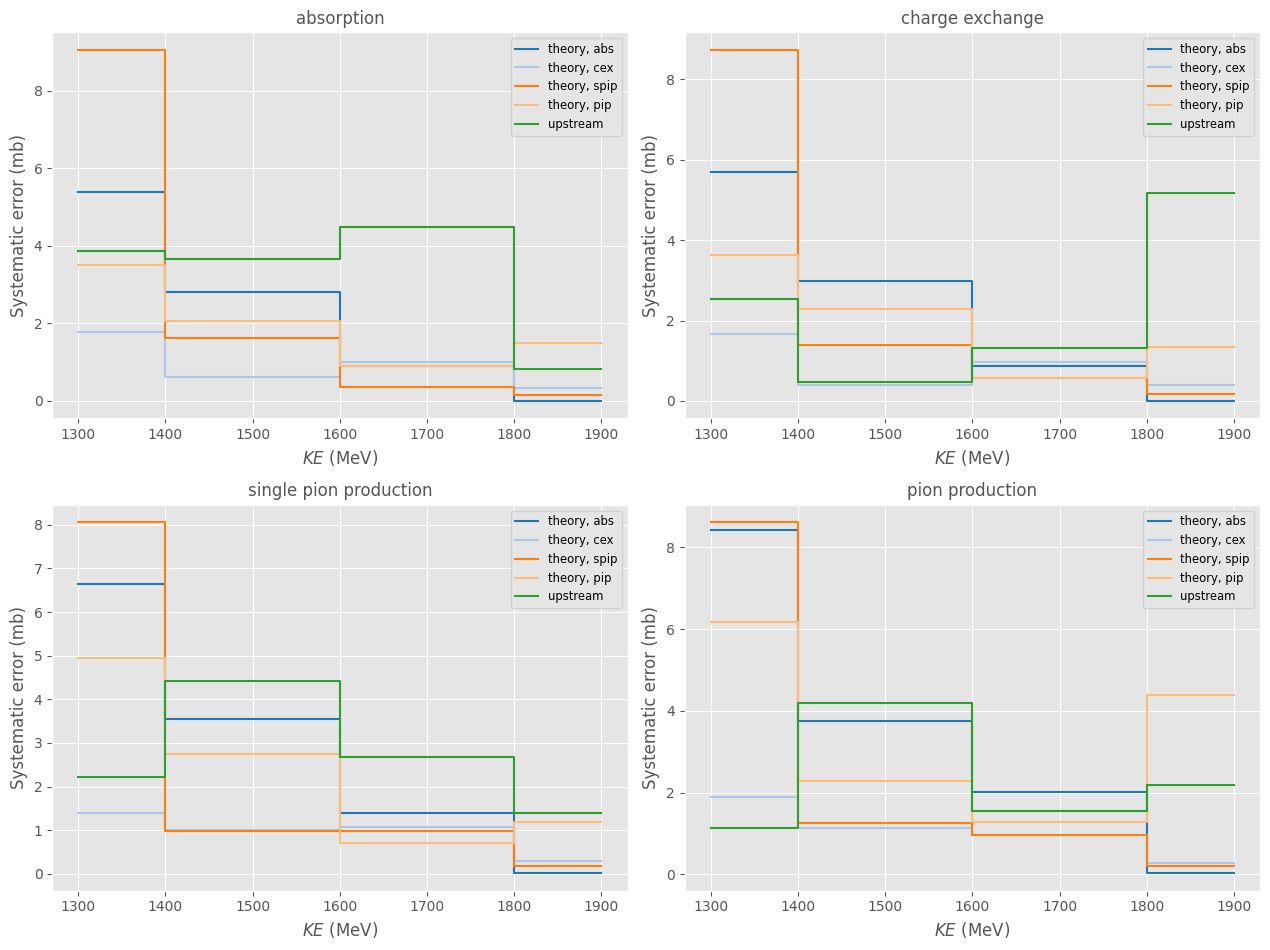

In [118]:
cex_systematics.PlotSysHist(systematics, args.energy_slices)

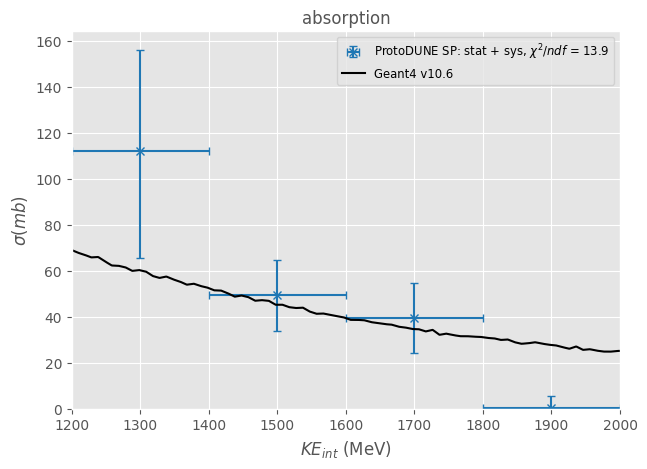

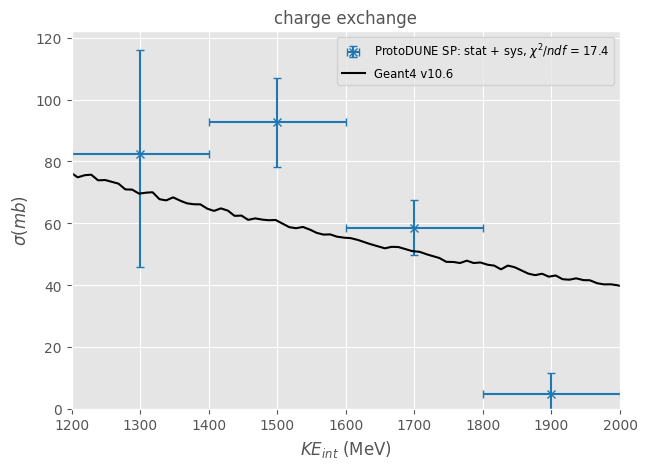

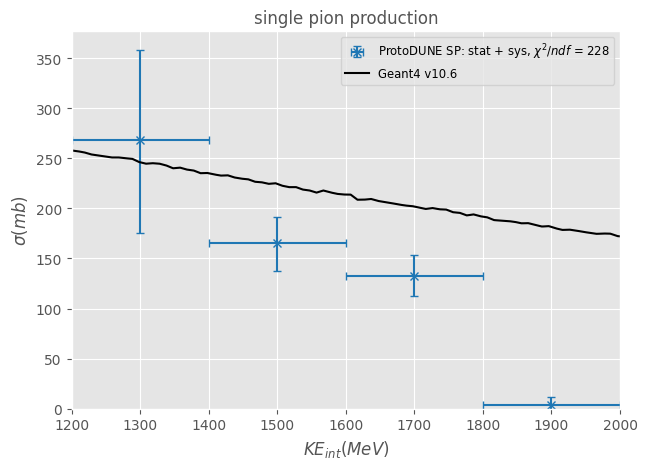

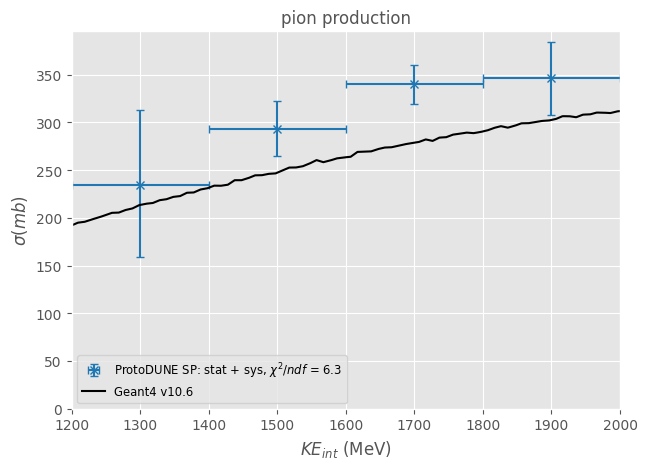

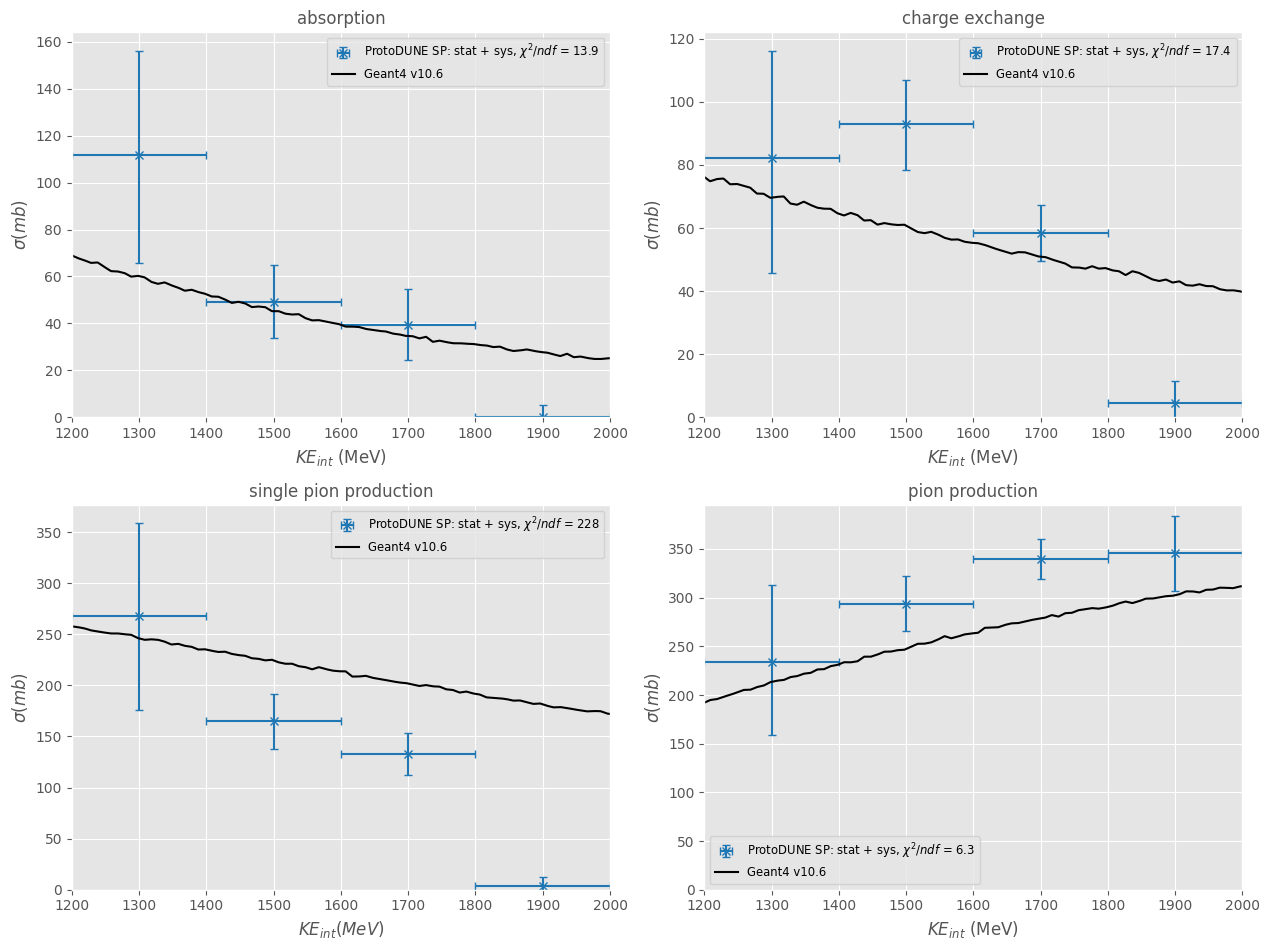

In [119]:
cex_systematics.FinalPlots(cv, systematics, args.energy_slices)